In [2]:
# Preparo entorno de ejecucion
import pandas as pd
import numpy as np
import re

In [3]:
# Cargo data en data frame
df = pd.read_csv('properatti.csv')
print("Tamanio del data frame: ", df.shape[1], " columnas y ", df.shape[0], " filas")

Tamanio del data frame:  26  columnas y  121220  filas


# Objetivo Principal
## Determinar el precio por metro cuadrado de un imueble
Primero vamos a eliminar columnas irrelevantes para este estudio
Entre estas tenemos: 
> 'properati_url' : Url en la base de properati
> 'image_thumbnail' : Url de la imagen de la primer foto
> 'geonames_id' : id de geonames
 

In [4]:
df.pop('Unnamed: 0')
df.pop('properati_url')
df.pop('image_thumbnail')
df.pop('geonames_id')
df.columns

Index(['operation', 'property_type', 'place_name', 'place_with_parent_names',
       'country_name', 'state_name', 'lat-lon', 'lat', 'lon', 'price',
       'currency', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'price_per_m2', 'floor', 'rooms', 'expenses', 'description', 'title'],
      dtype='object')

Vamos a ver que columnas se encuentran con valores nulos para luego poder completar los mismos con diferentes tecnicas de imputacion

In [5]:
# Extraigo las columnas que tiene valores nulos
haveEmptys = {}
for f in df.columns:
    emptys = df[f].isnull().sum()
    if emptys > 0:
        haveEmptys[f] = emptys
haveEmptys

{'place_name': 23,
 'lat-lon': 51550,
 'lat': 51550,
 'lon': 51550,
 'price': 20410,
 'currency': 20411,
 'price_aprox_local_currency': 20410,
 'price_aprox_usd': 20410,
 'surface_total_in_m2': 39328,
 'surface_covered_in_m2': 19907,
 'price_usd_per_m2': 52603,
 'price_per_m2': 33562,
 'floor': 113321,
 'rooms': 73830,
 'expenses': 106958,
 'description': 2}

Vamosa imprimir una muestra de cada uno de los campos que contiene campos vacios

In [6]:
for field in haveEmptys.keys():
    display(f'{field} : {df[field][np.random.randint(0, df.shape[0])]}')


'place_name : Tigre'

'lat-lon : nan'

'lat : -34.5895459'

'lon : nan'

'price : 350000.0'

'currency : ARS'

'price_aprox_local_currency : 1173359.25'

'price_aprox_usd : 116043.0'

'surface_total_in_m2 : nan'

'surface_covered_in_m2 : nan'

'price_usd_per_m2 : 1321.4285714285713'

'price_per_m2 : nan'

'floor : nan'

'rooms : 2.0'

'expenses : nan'

'description :   - Publicado por '

In [7]:
df.sample(10)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,...,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title
76762,sell,house,Longchamps,|Argentina|Bs.As. G.B.A. Zona Sur|Almirante Br...,Argentina,Bs.As. G.B.A. Zona Sur,"-34.8489566,-58.3928873",-34.848957,-58.392887,160000.0,...,160000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UBICADO EN LA CALLE CALLE BUNGE Nº3.442 ENTRE ...,VENDE:CASA
45531,sell,apartment,Caballito,|Argentina|Capital Federal|Caballito|,Argentina,Capital Federal,"-34.6211525,-58.4424341",-34.621153,-58.442434,230000.0,...,230000.00,105.0,101.0,2190.476190,2277.227723,3.0,4.0,3500.0,Venta de Departamento 5 AMBIENTES en Caballito...,DEPARTAMENTO EN VENTA
12675,sell,apartment,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,NaN,NaN,115000.0,...,115000.00,57.0,55.0,2017.543860,2090.909091,NaN,2.0,NaN,DEPARTAMENTO DE DOS AMBIENTES- CON COCHERA CUB...,DEPARTAMENTO DOS AMBIENTES-CON COCHERA CUBIERT...
1800,sell,apartment,Merlo,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|,Argentina,Bs.As. G.B.A. Zona Oeste,"-34.66457367,-58.70168304",-34.664574,-58.701683,NaN,...,NaN,65.0,65.0,NaN,NaN,NaN,2.0,NaN,MR-339EXCELENTE DEPARTAMENTO EN TORRES DEL GOL...,U$D 100.000 - Departamento en Venta - Independ...
102612,sell,apartment,Ituzaingó,|Argentina|Corrientes|Ituzaingó|,Argentina,Corrientes,NaN,NaN,NaN,195000.0,...,195000.00,79.0,73.0,2468.354430,2671.232877,NaN,NaN,NaN,DESARROLLO INMOBILIARIO EN PRE-POZ...,Departamento - Ituzaingó
102019,sell,apartment,Martínez,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,NaN,NaN,6074740.0,...,340693.75,111.0,71.0,3069.313063,85559.718310,NaN,NaN,NaN,"El Proyecto cuenta con Unidades de 2, 3 y 4 a...",Departamento en Pasionaria Martinez entrega 2018!
8633,sell,house,Salta,|Argentina|Salta|Salta|,Argentina,Salta,"-24.7845211,-65.4002475",-24.784521,-65.400247,NaN,...,NaN,300.0,174.0,NaN,NaN,NaN,6.0,NaN,Hermosa casa de 3 plantas ubicada en una zona ...,Casa venta
982,sell,apartment,Flores,|Argentina|Capital Federal|Flores|,Argentina,Capital Federal,"-34.617942,-58.460455",-34.617942,-58.460455,88000.0,...,88000.00,NaN,46.0,NaN,1913.043478,NaN,1.0,NaN,Corredor Responsable: Marcelo Trujillo - CUCIC...,En venta mono divisible a Estr/ FLORES con renta
103513,sell,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,NaN,NaN,NaN,1560000.0,...,87490.53,56.0,50.0,1562.330893,31200.000000,NaN,NaN,NaN,GARCIA ANDREU - Negocios Inmobiliarios- Ofrec...,Departamento Callao al 1000 - Macrocentro
17966,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,"-34.5607609,-58.4606042",-34.560761,-58.460604,330000.0,...,330000.00,85.0,75.0,3882.352941,4400.000000,NaN,NaN,7500.0,ES UN MODERNO DEPARTAMENTO CON DISENO UNICO Y ...,DEPARTAMENTO EN VENTA


### Imputacion de precio por valor en descripcion
Utilizando expresiones regulares vamos a intentar completar los valores de la columna precios obteniendo valos de la descripcion.


In [8]:
# Filas que contienen valores nulos en la columna "price"
priceIsNull = df[df['price'].isnull()]
priceIsNull.shape

(20410, 22)

In [9]:
priceIsNull.iloc[np.random.randint(0, priceIsNull.shape[1])]['description']

'CHALET EN DOS PLANTASCOMODIDADES:PB: living comedor - cocina comedor diario - baño completo - galería - garage pasante - fondo - pileta de natación - cuarto guarda útiles - lavaderoPA: 3 dormitorios (2 con altillo) - baño completo Medidas:Frente: 10 m Largo: 26 m. EasyBroker ID: 89447'

In [10]:
# Expresion regular para extraer el precio de la descripcion

for i in range(priceIsNull.shape[0]):
    priceIsNull.iloc[i]['description']


<AxesSubplot:>

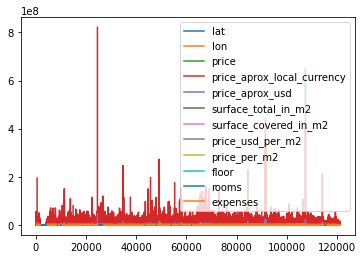

In [21]:
df.plot()